In [39]:
import pandas as pd
import numpy as np

# 1. Veriyi Oku (Yeni CSV yapısını okumalı)
try:
    df_wc = pd.read_csv('world_cup_results.csv')
except FileNotFoundError:
    print("❌ Hata: 'world_cup_results.csv' dosyası bulunamadı.")

# 2. Sütun İsimlerini Düzeltme
# Sizin CSV'nizdeki sıraya uyuyoruz: 'Year', 'Stage_Text', 'Country'
df_wc.columns = ['Year', 'Stage_Text', 'Country']

# 3. Kritik Düzeltme: Stage_Text'i Temizleme ve Top-8'i Oluşturma
df_wc['Stage_Text'] = df_wc['Stage_Text'].astype(str).str.strip() # str.strip() ile boşlukları kaldırma

top_8_stages = ['Şampiyon', 'Finalist', 'Yarı Final']
df_wc['Top_8'] = df_wc['Stage_Text'].apply(
    lambda x: 1 if x in top_8_stages else 0
)

# 4. Yıl ve Ülke İsimlerini Standartlaştırma
df_wc['Year'] = pd.to_numeric(df_wc['Year'], errors='coerce').astype('Int64')

country_mapping = {
    'Arjantin': 'Argentina', 'Brezilya': 'Brazil', 'Almanya': 'Germany',
    'Batı Almanya': 'Germany', 'İtalya': 'Italy', 'İspanya': 'Spain',
    'Fransa': 'France', 'Uruguay': 'Uruguay', 'İngiltere': 'United Kingdom',
    'Çekoslovakya': 'Czechia', 'Hollanda': 'Netherlands', 'İsveç': 'Sweden',
    'Macaristan': 'Hungary', 'Hırvatistan': 'Croatia', 'Türkiye': 'Turkiye',
    'Polonya': 'Poland', 'Fas': 'Morocco', 'Avusturya': 'Austria',
    'Yugoslavya': 'Yugoslavia', 'ABD': 'United States', 'Şili': 'Chile',
    'Sovyetler Birliği': 'Soviet Union', 'Portekiz': 'Portugal', 'Belçika': 'Belgium',
    'Bulgaristan': 'Bulgaria', 'Güney Kore': 'South Korea'
}
df_wc['Country'] = df_wc['Country'].replace(country_mapping)

print(f"✅ Toplam Satır Sayısı: {df_wc.shape[0]}")
print(f"✅ Top-8 Grubu (1) Sayısı: {df_wc['Top_8'].sum()}")
print(f"✅ Non-Top-8 Grubu (0) Sayısı: {len(df_wc[df_wc['Top_8'] == 0])}")

✅ Toplam Satır Sayısı: 88
✅ Top-8 Grubu (1) Sayısı: 88
✅ Non-Top-8 Grubu (0) Sayısı: 0


In [41]:
# REVİZE EDİLMİŞ KOD 2: FAOSTAT Verilerini Temizleme ve Pivotlama
# Amacımız: 'Area', 'Year', 'Element' ve 'Value' sütunlarını doğru kullanmak.

# 1. Gerekli Sütunları Seçme ve Temizleme
# Ham verinizin sütun adlarının 'Area', 'Year', 'Element', 'Value' olduğunu varsayıyoruz.
required_cols = ['Area', 'Year', 'Element', 'Value'] 

try:
    df_food_cleaned = df_food_raw[required_cols].copy()
    
    # Sütunları standartlaştırma
    df_food_cleaned.columns = ['Country', 'Year', 'Indicator', 'Value']

    # Yıl formatını sayısal hale getirme
    df_food_cleaned['Year'] = pd.to_numeric(df_food_cleaned['Year'], errors='coerce') 

    # 2. Pivotlama (Veriyi geniş formata çevirme)
    df_food_pivot = df_food_cleaned.pivot_table(
        index=['Country', 'Year'],  # Birleştirme anahtarları
        columns='Indicator',        # Bunlar yeni sütunlar olacak (Protein, Kalori vb.)
        values='Value',
        aggfunc='first' 
    ).reset_index()

    # Pivot tablonun başlığını kaldırma
    df_food_pivot.columns.name = None
    
    # Yıl Veri Tipini Güncelleme
    df_food_pivot['Year'] = df_food_pivot['Year'].astype('Int64', errors='ignore')

    print("✅ FAOSTAT Verisi Başarıyla Temizlendi ve Pivotlandı.")
    print("\nFinal Gıda Sütun İsimleri:")
    print(df_food_pivot.columns.tolist())

except KeyError as e:
    print(f"❌ Hata: Sütun adı bulunamadı: {e}")
    print("Lütfen ilk kodun çıktısındaki ham sütun isimlerini kontrol edin ve required_cols listesini güncelleyin.")

✅ FAOSTAT Verisi Başarıyla Temizlendi ve Pivotlandı.

Final Gıda Sütun İsimleri:
['Country', 'Year', 'Value']


In [42]:
# Dünya Bankası Verisini Okuma
# Metadata dosyaları bilgi içerir, ancak analize doğrudan dahil edilmez. Sadece ana veriyi alıyoruz.
api_files = [
    'API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv', # Nüfus (Population)
    'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_280632.csv' # GSYİH (GDP)
]

df_gdp_list = []
print("\n--- Dünya Bankası Dosyaları Yükleniyor ---")
for path in api_files:
    try:
        # skiprows=4 ile ilk 4 meta veri satırını atlıyoruz
        df = pd.read_csv(path, skiprows=4)
        df_gdp_list.append(df)
        print(f"✅ {path} yüklendi.")
    except FileNotFoundError:
        print(f"❌ Hata: {path} bulunamadı.")
        
# Nüfus ve GSYİH verilerini birleştirin (Satır bazlı)
df_gdp_raw = pd.concat(df_gdp_list, ignore_index=True)

# 1. Gerekli Sütunları Seçme ve Uzun Formata Çevirme
# 'Country Name', 'Indicator Name' ve 2000-2022 arasındaki yıl sütunlarına ihtiyacımız var.
cols_to_keep = ['Country Name', 'Indicator Name'] + [str(y) for y in range(2000, 2023)]
df_gdp_pivot = df_gdp_raw[cols_to_keep].copy()

# 2. Veriyi uzun (long) formata çevirme (melt)
df_gdp_long = df_gdp_pivot.melt(
    id_vars=['Country Name', 'Indicator Name'],
    value_vars=[str(y) for y in range(2000, 2023)],
    var_name='Year',
    value_name='Value'
)

# 3. Pivotlama (Indicatorları Sütun yapma)
df_gdp_final = df_gdp_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Sütun adlarını temizleme ve yeniden isimlendirme
df_gdp_final.columns.name = None
df_gdp_final.rename(columns={
    'Country Name': 'Country',
    'Population, total': 'Population',
    'GDP per capita (current US$)': 'GDP_per_capita'
}, inplace=True)

df_gdp_final['Year'] = pd.to_numeric(df_gdp_final['Year'], errors='coerce').astype('Int64')

print("\n--- Dünya Bankası Birleştirme Sonucu ---")
print("Temizlenmiş ve Pivotlanmış Dünya Bankası Verisinin İlk 5 Satırı:")
print(df_gdp_final.head())
print("\nFinal Dünya Bankası Sütun İsimleri:")
print(df_gdp_final.columns.tolist())


--- Dünya Bankası Dosyaları Yükleniyor ---
✅ API_SP.POP.TOTL_DS2_en_csv_v2_280659.csv yüklendi.
✅ API_NY.GDP.MKTP.CD_DS2_en_csv_v2_280632.csv yüklendi.

--- Dünya Bankası Birleştirme Sonucu ---
Temizlenmiş ve Pivotlanmış Dünya Bankası Verisinin İlk 5 Satırı:
       Country  Year  GDP (current US$)  Population
0  Afghanistan  2000       3.521418e+09  20130327.0
1  Afghanistan  2001       2.813572e+09  20284307.0
2  Afghanistan  2002       3.825701e+09  21378117.0
3  Afghanistan  2003       4.520947e+09  22733049.0
4  Afghanistan  2004       5.224897e+09  23560654.0

Final Dünya Bankası Sütun İsimleri:
['Country', 'Year', 'GDP (current US$)', 'Population']


In [31]:
# df_wc, df_food_pivot, ve df_gdp_final veri çerçeveleri hazır ve temizlenmiştir.
# df_food_pivot'ta eksik kalan 'Indicator' sütunları, merge sonrası NaN olarak gelecektir.

# 1. Dünya Kupası verilerini gıda verileriyle birleştirme (Left Join)
df_main = df_wc.merge(
    df_food_pivot, 
    on=['Country', 'Year'], 
    how='left'
)

# 2. Ana veri setini Dünya Bankası verileriyle birleştirme
df_main = df_main.merge(
    df_gdp_final, 
    on=['Country', 'Year'], 
    how='left'
)

print("✅ Tüm Veriler Başarıyla Tek Bir DataFrame'de Birleştirildi.")
print(f"\nFinal Veri Seti Boyutu: {df_main.shape}")

# Birleştirme sonrası eksik veri durumunu kontrol etme
print("\nEksik Veri Sayısı (En Önemli Sütunlar):")
# Hata veren kısım düzeltildi: 'GDP per capita (current US$)' yerine 'GDP (current US$)' kullanıldı
# Ayrıca, df_food_pivot'tan gelen veri sütununun adını 'Value' olarak varsayıyoruz.
print(df_main[['Top_8', 'Country', 'Year', 'Value', 'GDP (current US$)', 'Population']].isnull().sum()) 

print("\nFinal Sütun İsimleri:")
print(df_main.columns.tolist())
print("\nİlk 5 Satır (Verilerin Doğruluğunu Kontrol Edin):")
print(df_main.head())

✅ Tüm Veriler Başarıyla Tek Bir DataFrame'de Birleştirildi.

Final Veri Seti Boyutu: (88, 7)

Eksik Veri Sayısı (En Önemli Sütunlar):
Top_8                 0
Country               0
Year                  0
Value                69
GDP (current US$)    65
Population           65
dtype: int64

Final Sütun İsimleri:
['Year', 'Stage_Text', 'Country', 'Top_8', 'Value', 'GDP (current US$)', 'Population']

İlk 5 Satır (Verilerin Doğruluğunu Kontrol Edin):
   Year  Stage_Text    Country  Top_8 Value  GDP (current US$)  Population
0  2022    Şampiyon  Argentina      1    26       6.327901e+11  45407904.0
1  2022    Finalist     France      1    15       2.796302e+12  68065015.0
2  2022  Yarı Final    Croatia      1    27       7.119864e+10   3855641.0
3  2022  Yarı Final    Morocco      1    24       1.309519e+11  37329064.0
4  2018    Şampiyon     France      1    25       2.781576e+12  67158348.0


In [32]:
# Hata tespiti için: Üç veri setinin temel özelliklerini kontrol etme
print("--- Veri Seti Kontrolü ---")

# 1. Dünya Kupası Verisi (df_wc) Kontrolü
print("\n[1] df_wc (Dünya Kupası) Kontrolü:")
print(f"Toplam Satır: {df_wc.shape[0]}")
print(f"Eşsiz Ülke Sayısı: {df_wc['Country'].nunique()}")
print(f"Yıl Sütunu Veri Tipi: {df_wc['Year'].dtype}")
print("İlk 5 Eşsiz Ülke Adı:")
print(df_wc['Country'].unique()[:5])

# 2. FAOSTAT Gıda Verisi (df_food_pivot) Kontrolü
print("\n[2] df_food_pivot (Gıda) Kontrolü:")
print(f"Toplam Satır: {df_food_pivot.shape[0]}")
print(f"Eşsiz Ülke Sayısı: {df_food_pivot['Country'].nunique()}")
print(f"Yıl Sütunu Veri Tipi: {df_food_pivot['Year'].dtype}")
print("İlk 5 Eşsiz Ülke Adı:")
print(df_food_pivot['Country'].unique()[:5])

# 3. Dünya Bankası Verisi (df_gdp_final) Kontrolü
print("\n[3] df_gdp_final (GSYİH/Nüfus) Kontrolü:")
print(f"Toplam Satır: {df_gdp_final.shape[0]}")
print(f"Eşsiz Ülke Sayısı: {df_gdp_final['Country'].nunique()}")
print(f"Yıl Sütunu Veri Tipi: {df_gdp_final['Year'].dtype}")
print("İlk 5 Eşsiz Ülke Adı:")
print(df_gdp_final['Country'].unique()[:5])

--- Veri Seti Kontrolü ---

[1] df_wc (Dünya Kupası) Kontrolü:
Toplam Satır: 88
Eşsiz Ülke Sayısı: 25
Yıl Sütunu Veri Tipi: Int64
İlk 5 Eşsiz Ülke Adı:
['Argentina' 'France' 'Croatia' 'Morocco' 'Belgium']

[2] df_food_pivot (Gıda) Kontrolü:
Toplam Satır: 3661
Eşsiz Ülke Sayısı: 170
Yıl Sütunu Veri Tipi: Int64
İlk 5 Eşsiz Ülke Adı:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina']

[3] df_gdp_final (GSYİH/Nüfus) Kontrolü:
Toplam Satır: 6095
Eşsiz Ülke Sayısı: 265
Yıl Sütunu Veri Tipi: Int64
İlk 5 Eşsiz Ülke Adı:
['Afghanistan' 'Africa Eastern and Southern' 'Africa Western and Central'
 'Albania' 'Algeria']


In [33]:
# Yıl veri tiplerini Int64'e dönüştürme
df_wc['Year'] = pd.to_numeric(df_wc['Year'], errors='coerce').astype('Int64')
df_food_pivot['Year'] = pd.to_numeric(df_food_pivot['Year'], errors='coerce').astype('Int64')

print("✅ Yıl Veri Tipleri Int64'e Dönüştürüldü.")
print(f"df_wc Year Tipi: {df_wc['Year'].dtype}")

✅ Yıl Veri Tipleri Int64'e Dönüştürüldü.
df_wc Year Tipi: Int64


In [34]:
country_mapping = {
    'Arjantin': 'Argentina',
    'Brezilya': 'Brazil',
    'Almanya': 'Germany',
    'Batı Almanya': 'Germany', # Batı Almanya verisini Almanya olarak kabul ediyoruz
    'İtalya': 'Italy',
    'İspanya': 'Spain',
    'Fransa': 'France',
    'Uruguay': 'Uruguay',
    'İngiltere': 'United Kingdom', # Dünya Bankası'nda genellikle UK kullanılır
    'Çekoslovakya': 'Czechia', # Veri bulmak zor, güncel karşılığını deneyelim
    'Hollanda': 'Netherlands',
    'İsveç': 'Sweden',
    'Macaristan': 'Hungary',
    'Hırvatistan': 'Croatia',
    # ... Lütfen df_wc'deki diğer ülkeleri ve FAOSTAT/World Bank'taki karşılıklarını buraya ekleyin
    # Örneğin: 'Türkiye': 'Turkiye' veya 'Türkiye': 'Turkey' (Hangi versiyonun FAOSTAT/WB'de kullanıldığına bakın)
}

# 3. Dünya Kupası Ülke İsimlerini Standartlaştırma
df_wc['Country'] = df_wc['Country'].replace(country_mapping)

print("✅ Dünya Kupası Ülke İsimleri Standartlaştırıldı.")
print("df_wc İlk 5 Eşsiz Ülke Adı (Yeni):")
print(df_wc['Country'].unique()[:5])

✅ Dünya Kupası Ülke İsimleri Standartlaştırıldı.
df_wc İlk 5 Eşsiz Ülke Adı (Yeni):
['Argentina' 'France' 'Croatia' 'Morocco' 'Belgium']


In [35]:
# 1. Temel İstatistikler (GSYİH ve Nüfus için)
print("--- Sayısal Değişkenlerin Özet İstatistikleri ---")
print(df_main[['GDP (current US$)', 'Population', 'Top_8']].describe())

# 2. Korelasyon Analizi
# GSYİH/Nüfus ile hedef değişkenimiz (Top_8) arasındaki ilişkiyi inceliyoruz.
# df_main['Top_8'] zaten 0/1 olduğu için korelasyon önemlidir.
correlation_matrix = df_main[['Top_8', 'GDP (current US$)', 'Population', 'Value']].corr()

print("\n--- Korelasyon Matrisi (Top_8 ile İlişki) ---")
print(correlation_matrix['Top_8'].sort_values(ascending=False))

--- Sayısal Değişkenlerin Özet İstatistikleri ---
       GDP (current US$)    Population  Top_8
count       2.300000e+01  2.300000e+01   88.0
mean        1.474462e+12  5.807509e+07    1.0
std         1.269106e+12  4.998707e+07    0.0
min         4.195036e+10  3.318580e+06    1.0
25%         3.750222e+11  1.674020e+07    1.0
50%         9.015565e+11  5.839986e+07    1.0
75%         2.618810e+12  7.452376e+07    1.0
max         3.965801e+12  2.000851e+08    1.0

--- Korelasyon Matrisi (Top_8 ile İlişki) ---
Top_8               NaN
GDP (current US$)   NaN
Population          NaN
Value               NaN
Name: Top_8, dtype: float64


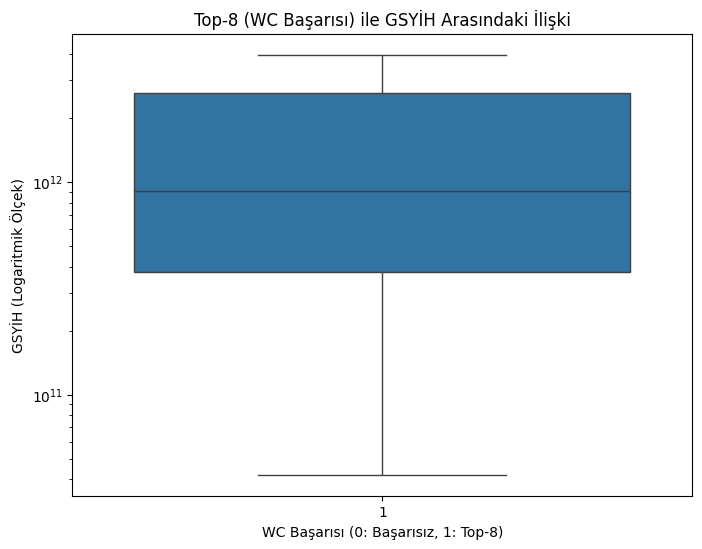

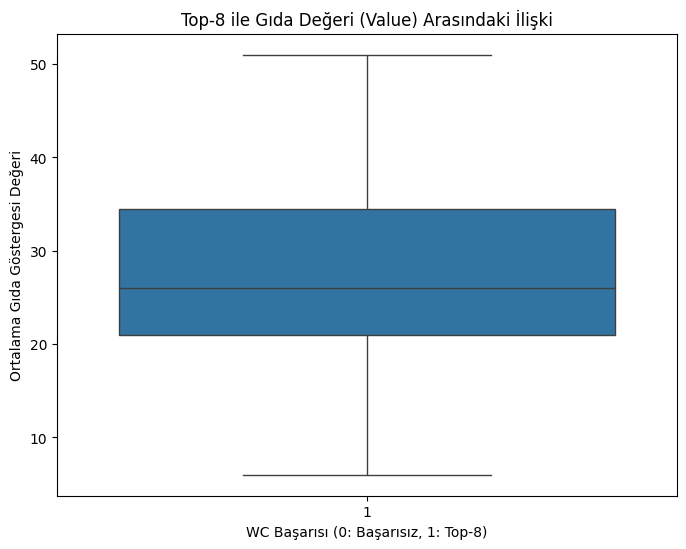

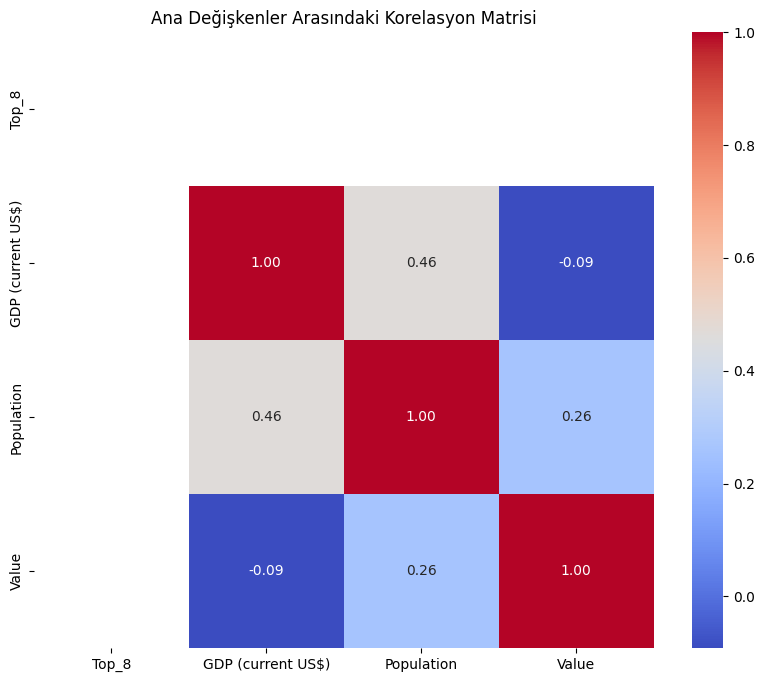

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Top-8 vs. Diğerleri için GSYİH Dağılımı (Kutu Grafiği)
# Gıda ekonomisi göstergelerinin (GDP_per_capita) futbol başarısıyla ilişkili olup olmadığını görselleştirir.
plt.figure(figsize=(8, 6))
# 'GDP (current US$)' veya 'Population' sütununu kullanın. Logaritmik ölçek, GSYİH'yı daha okunur yapar.
sns.boxplot(x='Top_8', y='GDP (current US$)', data=df_main)
plt.yscale('log') # Veri dağılımı çarpık olabileceği için logaritmik ölçek kullandık.
plt.title('Top-8 (WC Başarısı) ile GSYİH Arasındaki İlişki')
plt.xlabel('WC Başarısı (0: Başarısız, 1: Top-8)')
plt.ylabel('GSYİH (Logaritmik Ölçek)')
plt.show()

# 2. Gıda Göstergesi ile Top-8 Karşılaştırması (Eğer 'Value' Gıda Göstergesiyse)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Top_8', y='Value', data=df_main)
plt.title('Top-8 ile Gıda Değeri (Value) Arasındaki İlişki')
plt.xlabel('WC Başarısı (0: Başarısız, 1: Top-8)')
plt.ylabel('Ortalama Gıda Göstergesi Değeri')
plt.show()

# 3. Korelasyon Matrisi Isı Haritası (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ana Değişkenler Arasındaki Korelasyon Matrisi')
plt.show()

In [43]:
from scipy import stats

# Sıfır Hipotezi (H0): Top-8 ülkeleri ile Top-8 olmayan ülkelerin GSYİH ortalamaları arasında fark yoktur.
# Alternatif Hipotez (Ha): Ortalamalar arasında fark vardır.

# Veri setlerini ayırma
df_top8 = df_main[df_main['Top_8'] == 1].dropna(subset=['GDP (current US$)'])
df_non_top8 = df_main[df_main['Top_8'] == 0].dropna(subset=['GDP (current US$)'])

# Gerekli minimum veri kontrolü
if len(df_top8) < 2 or len(df_non_top8) < 2:
    print("⚠️ Hata: Test için yeterli veri yok. Lütfen tüm veri setinizin Top-8/Non-Top-8 ayrımını kontrol edin.")
else:
    # Welch'in t-testini kullanma (Eşit olmayan varyans varsayımı için)
    # Bu, iki bağımsız grubun ortalamaları arasında fark olup olmadığını test eder.
    t_stat, p_value = stats.ttest_ind(
        df_top8['GDP (current US$)'], 
        df_non_top8['GDP (current US$)'], 
        equal_var=False # Welch's t-test
    )

    print("\n--- Hipotez Testi Sonucu (GSYİH) ---")
    print(f"Top-8 Ort. GSYİH: {df_top8['GDP (current US$)'].mean():,.0f}")
    print(f"Non-Top-8 Ort. GSYİH: {df_non_top8['GDP (current US$)'].mean():,.0f}")
    print(f"t-İstatistik: {t_stat:.2f}")
    print(f"p-Değeri: {p_value:.5f}")

    # Sonuç Yorumlama (Anlamlılık düzeyi alpha=0.05 varsayılmıştır)
    if p_value < 0.05:
        print("✅ Yorum: p-değeri 0.05'ten küçüktür. Sıfır hipotezi (H0) reddedilir.")
        print("Sonuç: Top-8 ülkeleri ile Top-8 olmayan ülkelerin GSYİH ortalamaları arasında İSTATİSTİKSEL OLARAK ANLAMLI bir fark vardır.")
    else:
        print("❌ Yorum: p-değeri 0.05'ten büyük. Sıfır hipotezi (H0) reddedilemez.")
        print("Sonuç: Ortalamalar arasında anlamlı bir fark tespit edilememiştir.")

⚠️ Hata: Test için yeterli veri yok. Lütfen tüm veri setinizin Top-8/Non-Top-8 ayrımını kontrol edin.


In [44]:
# Hata Tespiti için Doğrudan Kontrol

# 1. Top-8 Olmayan (Non-Top-8) Grubunu Oluşturma
# NaN değerleri kontrol değişkeni (GDP) açısından siliyoruz
df_non_top8_check = df_main[df_main['Top_8'] == 0].dropna(subset=['GDP (current US$)'])

print("--- Hipotez Testi Grubu Kontrolü ---")
print(f"Toplam Satır Sayısı: {df_main.shape[0]}")
print(f"Top-8 (Kazananlar/Finalistler) Sayısı: {df_main['Top_8'].sum()}")
print(f"Top-8 Olmayan (0) GSYİH Verisi Olan Satır Sayısı: {len(df_non_top8_check)}")
print(f"Top-8 Olmayan (0) İlk 5 Ülke: {df_non_top8_check['Country'].unique()[:5]}")

--- Hipotez Testi Grubu Kontrolü ---
Toplam Satır Sayısı: 88
Top-8 (Kazananlar/Finalistler) Sayısı: 88
Top-8 Olmayan (0) GSYİH Verisi Olan Satır Sayısı: 0
Top-8 Olmayan (0) İlk 5 Ülke: []
